In [4]:
import pypsa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

scenarios = ["base_eu_regain", "base_eu_maintain", "base_eu_deindustrial", "policy_eu_regain", "policy_eu_maintain", "policy_eu_deindustrial"]


INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


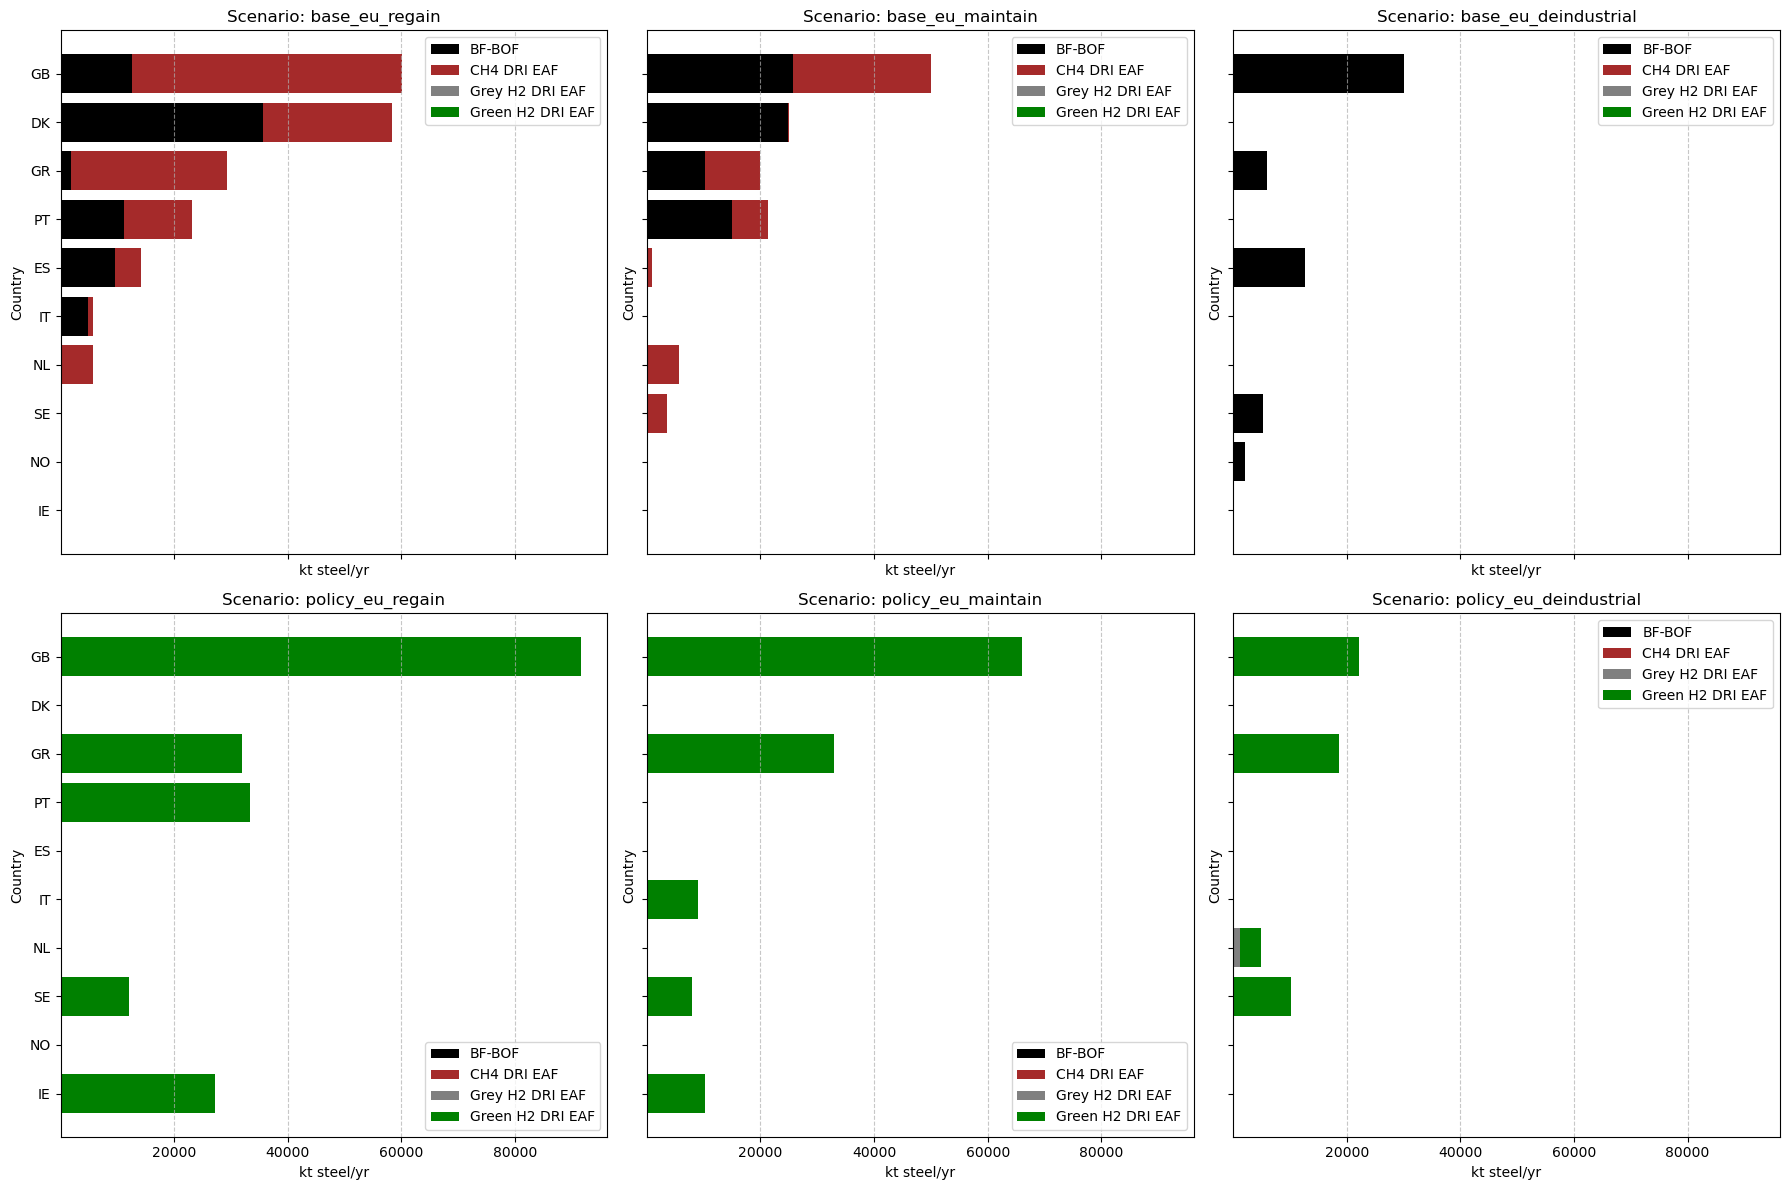

In [178]:
# Steel

def plot_steel_scenarios(scenarios):
    country_totals = {}  # Dictionary to track total production per country
    all_scenario_data = {}  # To store all relevant data for each scenario
    
    # First pass: Collect data across all scenarios
    for scenario in scenarios:
        # Load network once
        n = pypsa.Network(f"C:/Users/alice/Desktop/CMCC/pypsa-adb-industry/results/{scenario}/networks/base_s_39___2050.nc")
        timestep = n.snapshot_weightings.iloc[0, 0]

        # Extract EAF production
        p_nom_eaf = -n.links_t.p1.filter(like="EAF", axis=1).sum() * timestep
        p_nom_eaf.index = p_nom_eaf.index.str[:2]  # Keep only country code
        p_nom_eaf = p_nom_eaf[p_nom_eaf >= 0]  # Remove values below 0

        # Extract BOF production
        p_nom_bof = -n.links_t.p1.filter(like="BF-BOF", axis=1).sum() * timestep
        p_nom_bof.index = p_nom_bof.index.str[:2]  # Keep only country code
        p_nom_bof = p_nom_bof[p_nom_bof >= 0]  # Remove values below 0

        # Sum per country
        summed_p_nom_eaf = p_nom_eaf.groupby(p_nom_eaf.index).sum()
        summed_p_nom_bof = p_nom_bof.groupby(p_nom_bof.index).sum()

        # Get the combined index (union of both indices)
        all_countries = summed_p_nom_eaf.index.union(summed_p_nom_bof.index)

        # Reindex both DataFrames to ensure all countries are present
        summed_p_nom_eaf = summed_p_nom_eaf.reindex(all_countries, fill_value=0)
        summed_p_nom_bof = summed_p_nom_bof.reindex(all_countries, fill_value=0)

        # Extract H2 Clean and H2 Dirty production
        h2_clean = n.links.loc[n.links.index.str.contains('H2 Electrolysis|SMR CC', regex=True, na=False), :].index
        h2_dirty = n.links.loc[n.links.index.str.contains('SMR(?! CC)', regex=True, na=False), :].index
        h2_clean_df = -n.links_t.p1.loc[:, h2_clean].sum() * timestep
        h2_dirty_df = -n.links_t.p1.loc[:, h2_dirty].sum() * timestep

        # Summing by country code
        h2_clean_df.index = h2_clean_df.index.str[:2]
        h2_clean_df = h2_clean_df.groupby(h2_clean_df.index).sum()

        h2_dirty_df.index = h2_dirty_df.index.str[:2]
        h2_dirty_df = h2_dirty_df.groupby(h2_dirty_df.index).sum()

        # Calculate the share of green H2 and dirty H2
        share_green = round(h2_clean_df / (h2_clean_df + h2_dirty_df), 2)

        # Extract CH4 and H2-based DRI data
        dri_ch4 = -n.links_t.p1.filter(like='CH4 to syn gas DRI', axis=1).sum() * timestep
        dri_h2 = -n.links_t.p1.filter(like='H2 to syn gas DRI', axis=1).sum() * timestep

        # Calculate the share of H2 in DRI production -> at the European level now
        share_h2 = round(dri_h2.sum() / (dri_h2.sum() + dri_ch4.sum()), 2)

        # Calculate the adjusted EAF production
        summed_p_nom_ch4_eaf = summed_p_nom_eaf * (1 - share_h2)  # EAF with CH4
        summed_p_nom_grey_h2_eaf = summed_p_nom_eaf * share_h2 * (1 - share_green)  # EAF with Grey H2
        summed_p_nom_green_h2_eaf = summed_p_nom_eaf * share_h2 * share_green  # EAF with Green H2

        # Check if the sum matches the original summed_eaf
        if not np.allclose(summed_p_nom_ch4_eaf + summed_p_nom_grey_h2_eaf + summed_p_nom_green_h2_eaf, summed_p_nom_eaf, atol=1e-6):
            print(f"Error in scenario {scenario}: The sum of CH4, Grey H2, and Green H2 EAF does not match the original EAF within the threshold.")

        # Store data for plotting later
        all_scenario_data[scenario] = {
            "summed_p_nom_ch4_eaf": summed_p_nom_ch4_eaf,
            "summed_p_nom_grey_h2_eaf": summed_p_nom_grey_h2_eaf,
            "summed_p_nom_green_h2_eaf": summed_p_nom_green_h2_eaf,
            "summed_p_nom_bof": summed_p_nom_bof
        }

        # Store total production per country (sum across all scenarios)
        for country in all_countries:
            if country not in country_totals:
                country_totals[country] = 0
            country_totals[country] += summed_p_nom_eaf.get(country, 0) + summed_p_nom_bof.get(country, 0)

    # Identify countries to keep (remove those with total production = 0 across all scenarios)
    relevant_countries = [c for c, total in country_totals.items() if total > 1]

    # Second pass: Generate plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)
    axes = axes.flatten()  # Convert to 1D array for easy iteration

    for i, scenario in enumerate(scenarios):
        # Get the data for this scenario
        summed_p_nom_ch4_eaf = all_scenario_data[scenario]["summed_p_nom_ch4_eaf"]
        summed_p_nom_grey_h2_eaf = all_scenario_data[scenario]["summed_p_nom_grey_h2_eaf"]
        summed_p_nom_green_h2_eaf = all_scenario_data[scenario]["summed_p_nom_green_h2_eaf"]
        summed_p_nom_bof = all_scenario_data[scenario]["summed_p_nom_bof"]

        # Reindex using only the relevant countries
        summed_p_nom_ch4_eaf = summed_p_nom_ch4_eaf.reindex(relevant_countries, fill_value=0)
        summed_p_nom_grey_h2_eaf = summed_p_nom_grey_h2_eaf.reindex(relevant_countries, fill_value=0)
        summed_p_nom_green_h2_eaf = summed_p_nom_green_h2_eaf.reindex(relevant_countries, fill_value=0)
        summed_p_nom_bof = summed_p_nom_bof.reindex(relevant_countries, fill_value=0)

        # Sort by total production (EAF + BOF)
        total_production = summed_p_nom_ch4_eaf + summed_p_nom_grey_h2_eaf + summed_p_nom_green_h2_eaf + summed_p_nom_bof
        sorted_countries = total_production.sort_values().index

        # Reorder dataframes
        summed_p_nom_ch4_eaf = summed_p_nom_ch4_eaf[sorted_countries]
        summed_p_nom_grey_h2_eaf = summed_p_nom_grey_h2_eaf[sorted_countries]
        summed_p_nom_green_h2_eaf = summed_p_nom_green_h2_eaf[sorted_countries]
        summed_p_nom_bof = summed_p_nom_bof[sorted_countries]

        # Plot in subplot
        ax = axes[i]
        ax.barh(sorted_countries, summed_p_nom_bof.values, color="black", label="BF-BOF")
        ax.barh(sorted_countries, summed_p_nom_ch4_eaf.values, color="brown", label="CH4 DRI EAF", left=summed_p_nom_bof.values)
        ax.barh(sorted_countries, summed_p_nom_grey_h2_eaf.values, color="gray", label="Grey H2 DRI EAF", left=summed_p_nom_bof.values + summed_p_nom_ch4_eaf.values)
        ax.barh(sorted_countries, summed_p_nom_green_h2_eaf.values, color="green", label="Green H2 DRI EAF", left=summed_p_nom_bof.values + summed_p_nom_ch4_eaf.values + summed_p_nom_grey_h2_eaf.values)

        ax.set_xlabel("kt steel/yr")
        ax.set_ylabel("Country")
        ax.set_title(f"Scenario: {scenario}")
        ax.grid(axis="x", linestyle="--", alpha=0.7)
        ax.legend()

    plt.tight_layout()
    plt.savefig("./graphs/steel_production.png")
    plt.show()
    

# Example usage
plot_steel_scenarios(scenarios)


INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


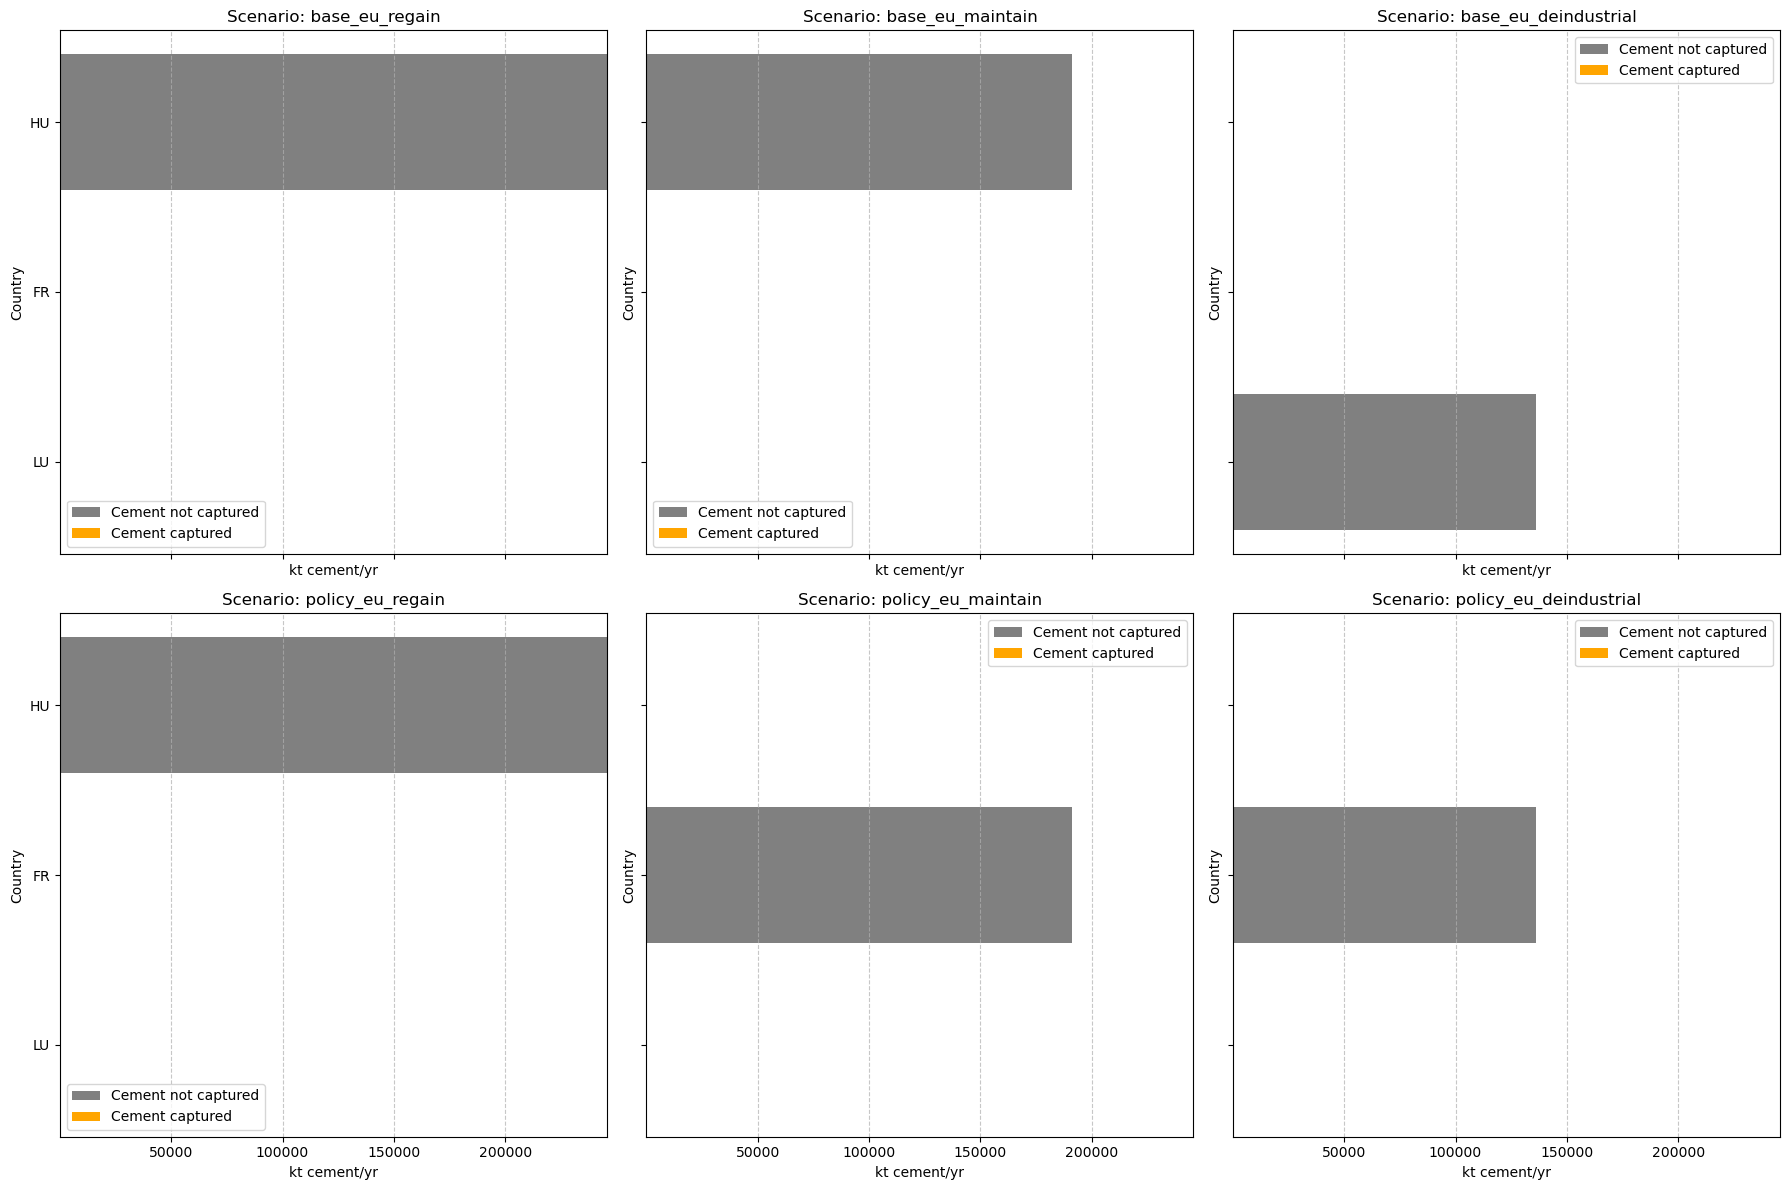

In [173]:
# Cement

def plot_cement_scenarios(scenarios):
    country_totals = {}  # Dictionary to track total production per country
    all_scenario_data = {}  # To store all relevant data for each scenario
    
    # First pass: Collect data across all scenarios
    for scenario in scenarios:
        # Load network once
        n = pypsa.Network(f"C:/Users/alice/Desktop/CMCC/pypsa-adb-industry/results/{scenario}/networks/base_s_39___2050.nc")
        timestep = n.snapshot_weightings.iloc[0, 0]

        # Extract cement production
        prod_cement = -n.links_t.p1.filter(like="Cement Plant", axis=1).sum() * timestep
        prod_cement.index = prod_cement.index.str[:2]  # Keep only country code
        prod_cement = prod_cement[prod_cement >= 0]  # Remove values below 0

        # Sum per country
        summed_prod_cement = prod_cement.groupby(prod_cement.index).sum()

        all_countries = summed_prod_cement.index

        # Extract cement emissions captured and not captured
        cement_not_captured = -n.links_t.p1.filter(like='cement process emis to atmosphere', axis=1).sum() * timestep
        cement_ccs = -n.links_t.p1.filter(like='cement CC', axis=1).sum() * timestep

        # Summing by country code
        cement_not_captured.index = cement_not_captured.index.str[:2]
        cement_not_captured = cement_not_captured.groupby(cement_not_captured.index).sum()

        cement_ccs.index = cement_ccs.index.str[:2]
        cement_ccs = cement_ccs.groupby(cement_ccs.index).sum()

        # Calculate the share of green H2 and dirty H2
        share_ccs = round(cement_ccs / (cement_ccs + cement_not_captured), 2)

        # Calculate the adjusted cement production
        summed_prod_cement_not_captured = summed_prod_cement * (1 - share_ccs) 
        summed_prod_cement_captured = summed_prod_cement * share_ccs 

        # Check if the sum matches the original summed_eaf
        if not np.allclose(summed_prod_cement_not_captured + summed_prod_cement_captured , summed_prod_cement, atol=1e-6):
            print(f"Error in scenario {scenario}: The sum of cement captured and not does not match the original cement production within the threshold.")

        # Store data for plotting later
        all_scenario_data[scenario] = {
            "summed_prod_cement_not_captured": summed_prod_cement_not_captured,
            "summed_prod_cement_captured": summed_prod_cement_captured,
        }

        # Store total production per country (sum across all scenarios)
        for country in all_countries:
            if country not in country_totals:
                country_totals[country] = 0
            country_totals[country] += summed_prod_cement_not_captured.get(country, 0) + summed_prod_cement_captured.get(country, 0)

    # Identify countries to keep (remove those with total production = 0 across all scenarios)
    relevant_countries = [c for c, total in country_totals.items() if total > 1]

    # Second pass: Generate plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)
    axes = axes.flatten()  # Convert to 1D array for easy iteration

    for i, scenario in enumerate(scenarios):
        # Get the data for this scenario
        summed_prod_cement_not_captured = all_scenario_data[scenario]["summed_prod_cement_not_captured"]
        summed_prod_cement_captured = all_scenario_data[scenario]["summed_prod_cement_captured"]

        # Reindex using only the relevant countries
        summed_prod_cement_not_captured = summed_prod_cement_not_captured.reindex(relevant_countries, fill_value=0)
        summed_prod_cement_captured = summed_prod_cement_captured.reindex(relevant_countries, fill_value=0)

        # Sort by total production
        total_production = summed_prod_cement_not_captured + summed_prod_cement_captured
        sorted_countries = total_production.sort_values().index

        # Reorder dataframes
        summed_prod_cement_not_captured = summed_prod_cement_not_captured[sorted_countries]
        summed_prod_cement_captured = summed_prod_cement_captured[sorted_countries]


        # Plot in subplot
        ax = axes[i]
        ax.barh(sorted_countries, summed_prod_cement_not_captured.values, color="gray", label="Cement not captured")
        ax.barh(sorted_countries, summed_prod_cement_captured.values, color="orange", label="Cement captured", left=summed_prod_cement_not_captured.values)

        ax.set_xlabel("kt cement/yr")
        ax.set_ylabel("Country")
        ax.set_title(f"Scenario: {scenario}")
        ax.grid(axis="x", linestyle="--", alpha=0.7)
        ax.legend()

    plt.tight_layout()
    plt.savefig("./graphs/cement_production.png")
    plt.show()
    

# Example usage
plot_cement_scenarios(scenarios)


INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


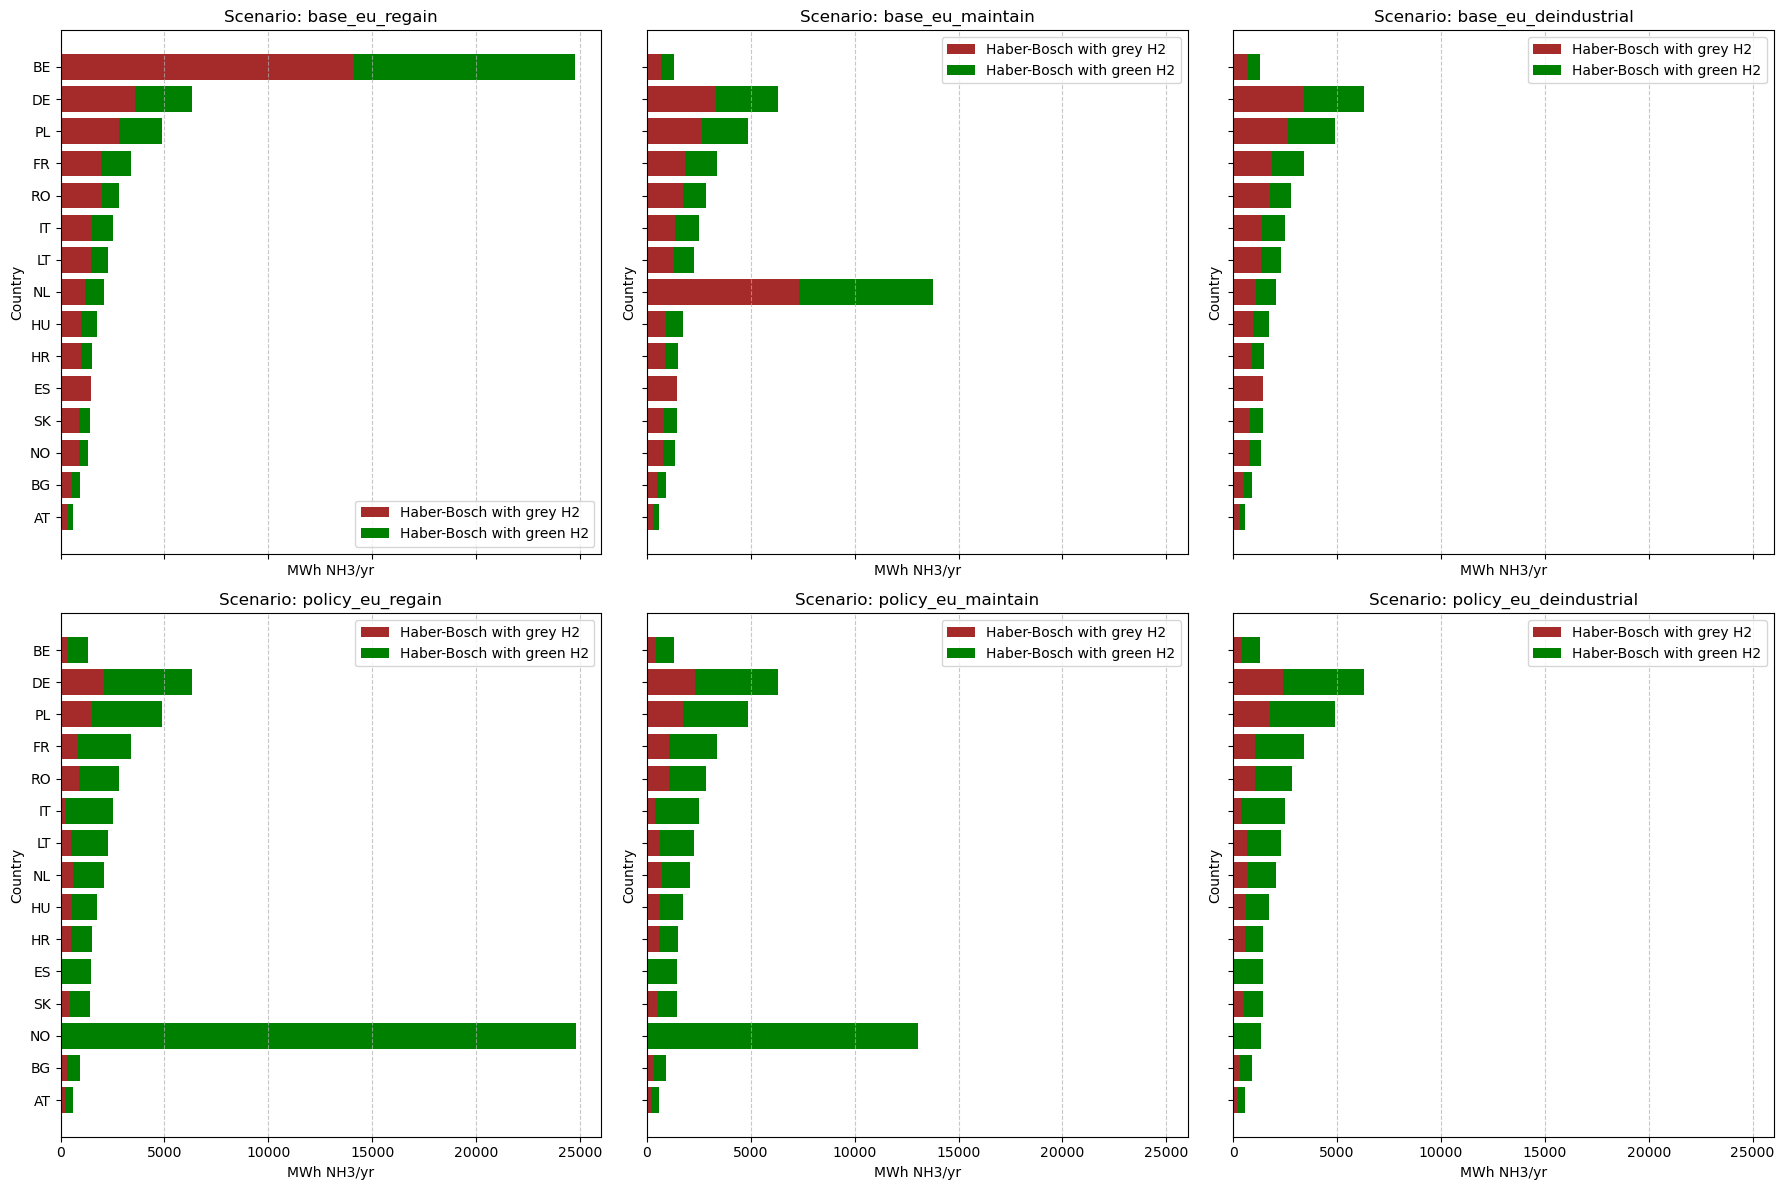

In [3]:
# Ammonia

def plot_ammonia_scenarios(scenarios):
    country_totals = {}  # Dictionary to track total production per country
    all_scenario_data = {}  # To store all relevant data for each scenario
    
    # First pass: Collect data across all scenarios
    for scenario in scenarios:
        # Load network once
        n = pypsa.Network(f"C:/Users/alice/Desktop/CMCC/pypsa-adb-industry/results/{scenario}/networks/base_s_39___2030.nc")
        timestep = n.snapshot_weightings.iloc[0, 0]

        # Extract ammonia production
        prod_nh3 = -n.links_t.p1.filter(like="Haber-Bosch", axis=1).sum() * timestep
        prod_nh3.index = prod_nh3.index.str[:2]  # Keep only country code
        prod_nh3 = prod_nh3[prod_nh3 >= 0]  # Remove values below 0

        # Sum per country
        prod_nh3 = prod_nh3.groupby(prod_nh3.index).sum()

        # Get the combined index (union of both indices)
        all_countries = prod_nh3.index

        # Extract H2 Clean and H2 Dirty production
        h2_clean = n.links.loc[n.links.index.str.contains('H2 Electrolysis|SMR CC', regex=True, na=False), :].index
        h2_dirty = n.links.loc[n.links.index.str.contains('SMR(?! CC)', regex=True, na=False), :].index
        h2_clean_df = -n.links_t.p1.loc[:, h2_clean].sum() * timestep
        h2_dirty_df = -n.links_t.p1.loc[:, h2_dirty].sum() * timestep

        # Summing by country code
        h2_clean_df.index = h2_clean_df.index.str[:2]
        h2_clean_df = h2_clean_df.groupby(h2_clean_df.index).sum()

        h2_dirty_df.index = h2_dirty_df.index.str[:2]
        h2_dirty_df = h2_dirty_df.groupby(h2_dirty_df.index).sum()

        # Calculate the share of green H2 and dirty H2
        share_green = round(h2_clean_df / (h2_clean_df + h2_dirty_df), 2)

        # Calculate the adjusted EAF production
        prod_nh3_green = prod_nh3 * share_green
        prod_nh3_grey = prod_nh3 * (1- share_green )  # Ammonia with Grey H2

        # Check if the sum matches the original summed_eaf
        if not np.allclose(prod_nh3_green + prod_nh3_grey, prod_nh3, atol=1e-6):
            print(f"Error in scenario {scenario}: The sum of Grey H2 and Green H2 ammonia does not match the original ammonia within the threshold.")

        # Store data for plotting later
        all_scenario_data[scenario] = {
            "prod_nh3_grey": prod_nh3_grey,
            "prod_nh3_green": prod_nh3_green,
        }

        # Store total production per country (sum across all scenarios)
        for country in all_countries:
            if country not in country_totals:
                country_totals[country] = 0
            country_totals[country] += prod_nh3_green.get(country, 0) + prod_nh3_grey.get(country, 0)

    # Identify countries to keep (remove those with total production = 0 across all scenarios)
    relevant_countries = [c for c, total in country_totals.items() if total > 1]

    # Second pass: Generate plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)
    axes = axes.flatten()  # Convert to 1D array for easy iteration

    for i, scenario in enumerate(scenarios):
        # Get the data for this scenario
        prod_nh3_green = all_scenario_data[scenario]["prod_nh3_green"]
        prod_nh3_grey = all_scenario_data[scenario]["prod_nh3_grey"]

        # Reindex using only the relevant countries
        prod_nh3_green = prod_nh3_green.reindex(relevant_countries, fill_value=0)
        prod_nh3_grey = prod_nh3_grey.reindex(relevant_countries, fill_value=0)

        # Sort by total production (EAF + BOF)
        total_production = prod_nh3_green + prod_nh3_grey
        sorted_countries = total_production.sort_values().index

        # Reorder dataframes
        prod_nh3_green = prod_nh3_green[sorted_countries]
        prod_nh3_grey = prod_nh3_grey[sorted_countries]

        # Plot in subplot
        ax = axes[i]
        ax.barh(sorted_countries, prod_nh3_grey.values, color="brown", label="Haber-Bosch with grey H2")
        ax.barh(sorted_countries, prod_nh3_green.values, color="green", label="Haber-Bosch with green H2", left=prod_nh3_grey.values)

        ax.set_xlabel("MWh NH3/yr")
        ax.set_ylabel("Country")
        ax.set_title(f"Scenario: {scenario}")
        ax.grid(axis="x", linestyle="--", alpha=0.7)
        ax.legend()

    plt.tight_layout()
    plt.savefig("./graphs/ammonia_production.png")
    plt.show()
    

# Example usage
plot_ammonia_scenarios(scenarios)


INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


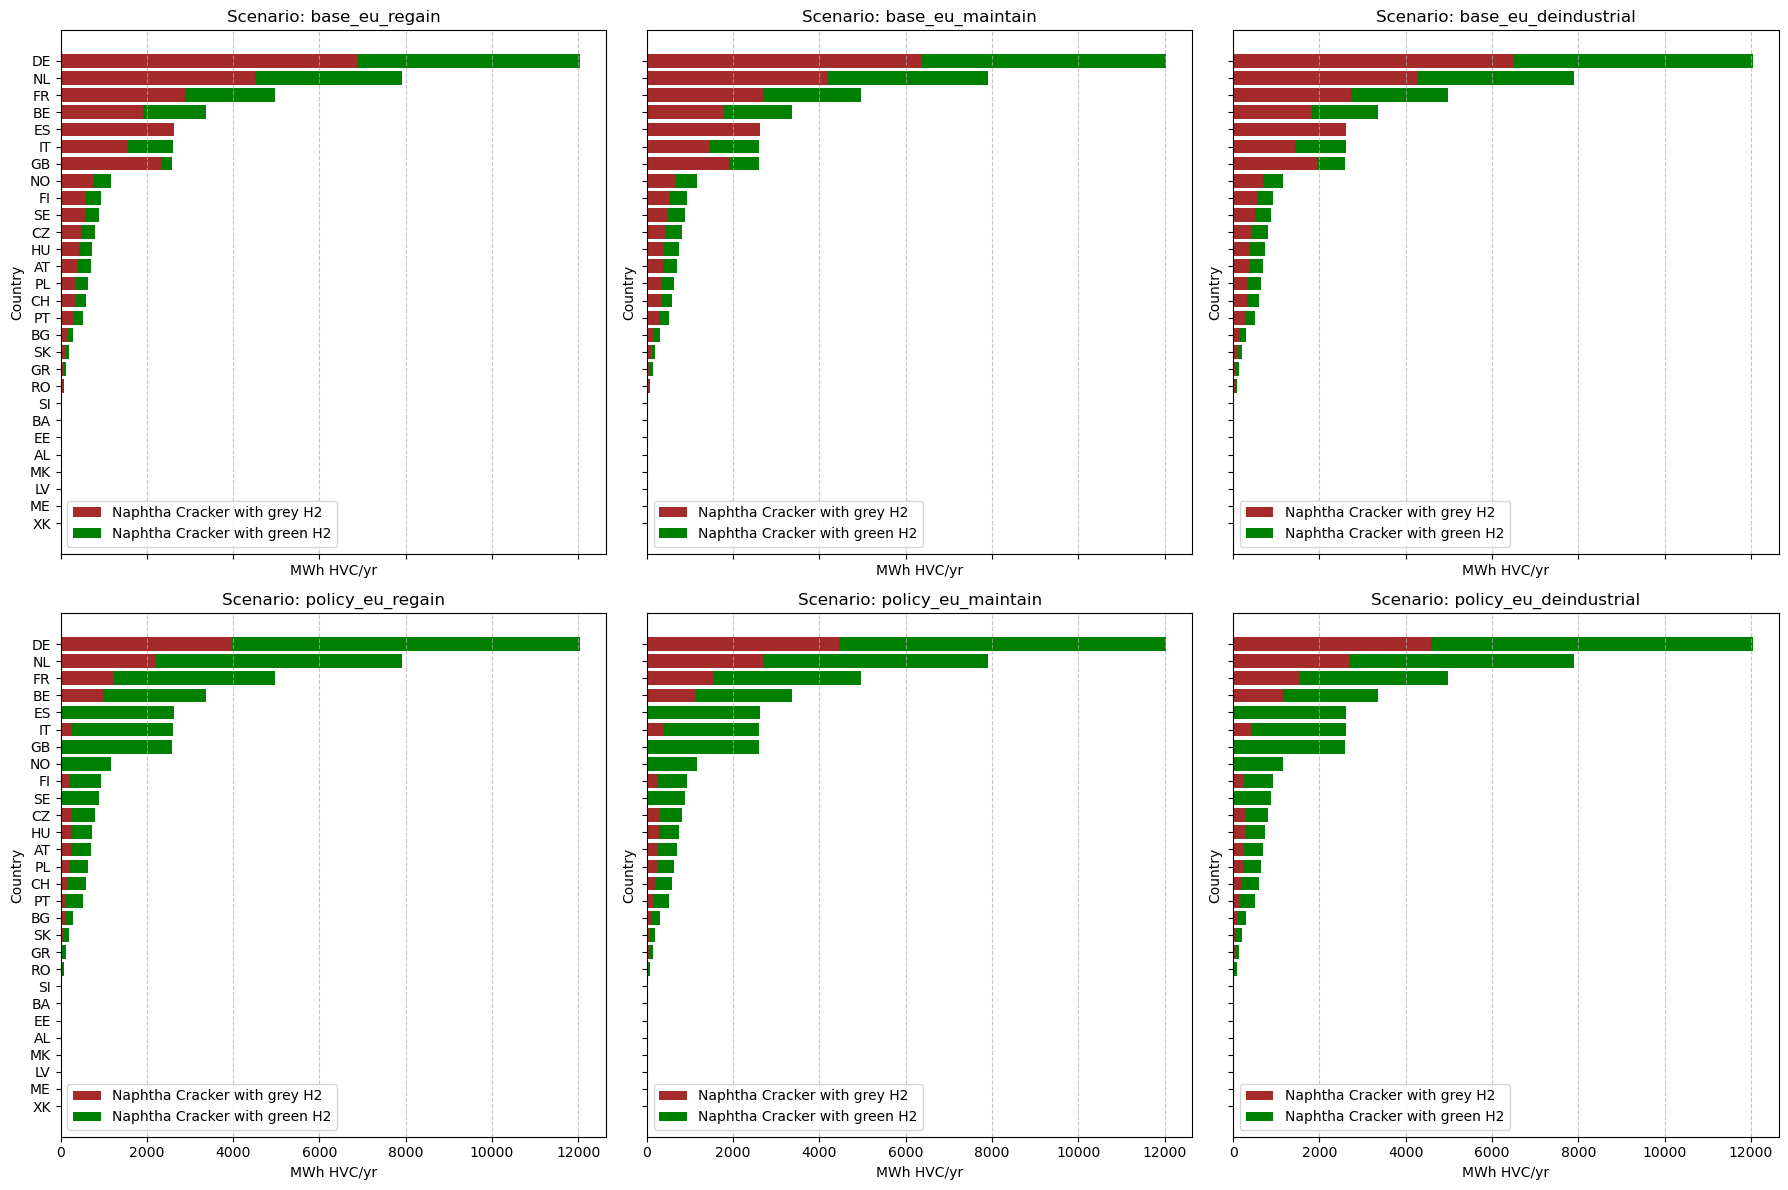

In [9]:

def plot_hvc_scenarios(scenarios):
    country_totals = {}  # Track total production per country
    all_scenario_data = {}  # Store data for each scenario
    
    for scenario in scenarios:
        n = pypsa.Network(f"C:/Users/alice/Desktop/CMCC/pypsa-adb-industry/results/{scenario}/networks/base_s_39___2030.nc")
        timestep = n.snapshot_weightings.iloc[0, 0]
        
        # Extract HVC production from naphtha steam crackers
        prod_hvc = -n.links_t.p1.filter(like="naphtha steam cracker", axis=1).sum() * timestep
        prod_hvc.index = prod_hvc.index.str[:2]  # Keep only country code
        prod_hvc = prod_hvc[prod_hvc >= 0]  # Remove negative values
        prod_hvc = prod_hvc.groupby(prod_hvc.index).sum()
        
        all_countries = prod_hvc.index
        
        # Extract H2 Clean and H2 Dirty production
        h2_clean = n.links.loc[n.links.index.str.contains('H2 Electrolysis|SMR CC', regex=True, na=False), :].index
        h2_dirty = n.links.loc[n.links.index.str.contains('SMR(?! CC)', regex=True, na=False), :].index
        h2_clean_df = -n.links_t.p1.loc[:, h2_clean].sum() * timestep
        h2_dirty_df = -n.links_t.p1.loc[:, h2_dirty].sum() * timestep
        
        h2_clean_df.index = h2_clean_df.index.str[:2]
        h2_clean_df = h2_clean_df.groupby(h2_clean_df.index).sum()
        
        h2_dirty_df.index = h2_dirty_df.index.str[:2]
        h2_dirty_df = h2_dirty_df.groupby(h2_dirty_df.index).sum()
        
        # Calculate share of green and grey H2
        share_green = round(h2_clean_df / (h2_clean_df + h2_dirty_df), 2)
        
        # Adjust HVC production based on H2 type
        prod_hvc_green = prod_hvc * share_green
        prod_hvc_grey = prod_hvc * (1 - share_green)
        
        if not np.allclose(prod_hvc_green + prod_hvc_grey, prod_hvc, atol=1e-6):
            print(f"Error in scenario {scenario}: The sum of Grey H2 and Green H2 HVC does not match the original HVC production.")
        
        all_scenario_data[scenario] = {
            "prod_hvc_grey": prod_hvc_grey,
            "prod_hvc_green": prod_hvc_green,
        }
        
        for country in all_countries:
            if country not in country_totals:
                country_totals[country] = 0
            country_totals[country] += prod_hvc_green.get(country, 0) + prod_hvc_grey.get(country, 0)
    
    relevant_countries = [c for c, total in country_totals.items() if total > 0.1]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, scenario in enumerate(scenarios):
        prod_hvc_green = all_scenario_data[scenario]["prod_hvc_green"].reindex(relevant_countries, fill_value=0)
        prod_hvc_grey = all_scenario_data[scenario]["prod_hvc_grey"].reindex(relevant_countries, fill_value=0)
        
        total_production = prod_hvc_green + prod_hvc_grey
        sorted_countries = total_production.sort_values().index
        
        prod_hvc_green = prod_hvc_green[sorted_countries]
        prod_hvc_grey = prod_hvc_grey[sorted_countries]
        
        ax = axes[i]
        ax.barh(sorted_countries, prod_hvc_grey.values, color="brown", label="Naphtha Cracker with grey H2")
        ax.barh(sorted_countries, prod_hvc_green.values, color="green", label="Naphtha Cracker with green H2", left=prod_hvc_grey.values)
        
        ax.set_xlabel("MWh HVC/yr")
        ax.set_ylabel("Country")
        ax.set_title(f"Scenario: {scenario}")
        ax.grid(axis="x", linestyle="--", alpha=0.7)
        ax.legend()
    
    plt.tight_layout()
    plt.savefig("./graphs/hvc_production.png")
    plt.show()

# Example usage
plot_hvc_scenarios(scenarios)


INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


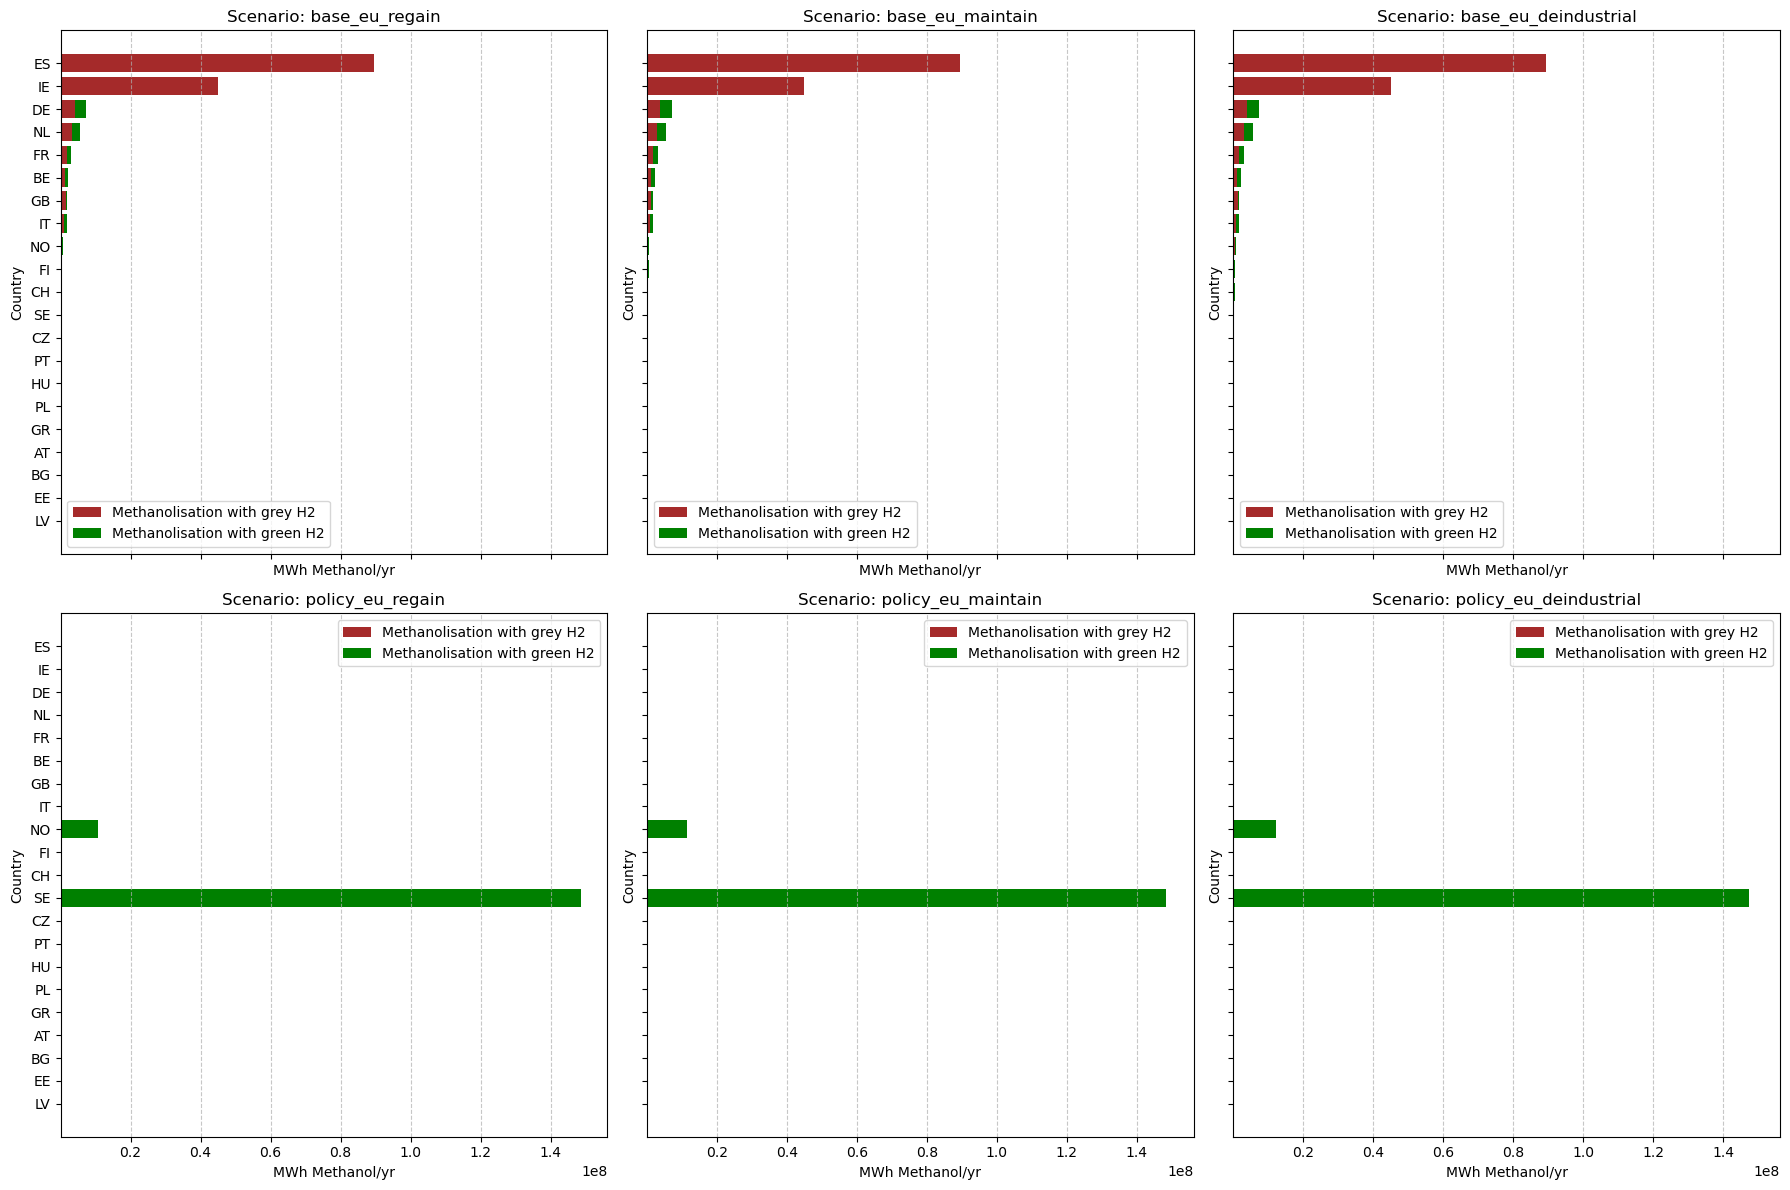

In [10]:
def plot_methanol_scenarios(scenarios):
    country_totals = {}  # Track total production per country
    all_scenario_data = {}  # Store data for each scenario
    
    for scenario in scenarios:
        n = pypsa.Network(f"C:/Users/alice/Desktop/CMCC/pypsa-adb-industry/results/{scenario}/networks/base_s_39___2030.nc")
        timestep = n.snapshot_weightings.iloc[0, 0]
        
        # Extract methanol production from methanolisation plants
        prod_methanol = -n.links_t.p1.filter(like="methanolisation", axis=1).sum() * timestep
        prod_methanol.index = prod_methanol.index.str[:2]  # Keep only country code
        prod_methanol = prod_methanol[prod_methanol >= 0]  # Remove negative values
        prod_methanol = prod_methanol.groupby(prod_methanol.index).sum()
        
        all_countries = prod_methanol.index
        
        # Extract H2 Clean and H2 Dirty production
        h2_clean = n.links.loc[n.links.index.str.contains('H2 Electrolysis|SMR CC', regex=True, na=False), :].index
        h2_dirty = n.links.loc[n.links.index.str.contains('SMR(?! CC)', regex=True, na=False), :].index
        h2_clean_df = -n.links_t.p1.loc[:, h2_clean].sum() * timestep
        h2_dirty_df = -n.links_t.p1.loc[:, h2_dirty].sum() * timestep
        
        h2_clean_df.index = h2_clean_df.index.str[:2]
        h2_clean_df = h2_clean_df.groupby(h2_clean_df.index).sum()
        
        h2_dirty_df.index = h2_dirty_df.index.str[:2]
        h2_dirty_df = h2_dirty_df.groupby(h2_dirty_df.index).sum()
        
        # Calculate share of green and grey H2
        share_green = round(h2_clean_df / (h2_clean_df + h2_dirty_df), 2)
        
        # Adjust methanol production based on H2 type
        prod_methanol_green = prod_methanol * share_green
        prod_methanol_grey = prod_methanol * (1 - share_green)
        
        if not np.allclose(prod_methanol_green + prod_methanol_grey, prod_methanol, atol=1e-6):
            print(f"Error in scenario {scenario}: The sum of Grey H2 and Green H2 methanol does not match the original methanol production.")
        
        all_scenario_data[scenario] = {
            "prod_methanol_grey": prod_methanol_grey,
            "prod_methanol_green": prod_methanol_green,
        }
        
        for country in all_countries:
            if country not in country_totals:
                country_totals[country] = 0
            country_totals[country] += prod_methanol_green.get(country, 0) + prod_methanol_grey.get(country, 0)
    
    relevant_countries = [c for c, total in country_totals.items() if total > 1]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, scenario in enumerate(scenarios):
        prod_methanol_green = all_scenario_data[scenario]["prod_methanol_green"].reindex(relevant_countries, fill_value=0)
        prod_methanol_grey = all_scenario_data[scenario]["prod_methanol_grey"].reindex(relevant_countries, fill_value=0)
        
        total_production = prod_methanol_green + prod_methanol_grey
        sorted_countries = total_production.sort_values().index
        
        prod_methanol_green = prod_methanol_green[sorted_countries]
        prod_methanol_grey = prod_methanol_grey[sorted_countries]
        
        ax = axes[i]
        ax.barh(sorted_countries, prod_methanol_grey.values, color="brown", label="Methanolisation with grey H2")
        ax.barh(sorted_countries, prod_methanol_green.values, color="green", label="Methanolisation with green H2", left=prod_methanol_grey.values)
        
        ax.set_xlabel("MWh Methanol/yr")
        ax.set_ylabel("Country")
        ax.set_title(f"Scenario: {scenario}")
        ax.grid(axis="x", linestyle="--", alpha=0.7)
        ax.legend()
    
    plt.tight_layout()
    plt.savefig("./graphs/methanol_production.png")
    plt.show()

# Example usage
plot_methanol_scenarios(scenarios)


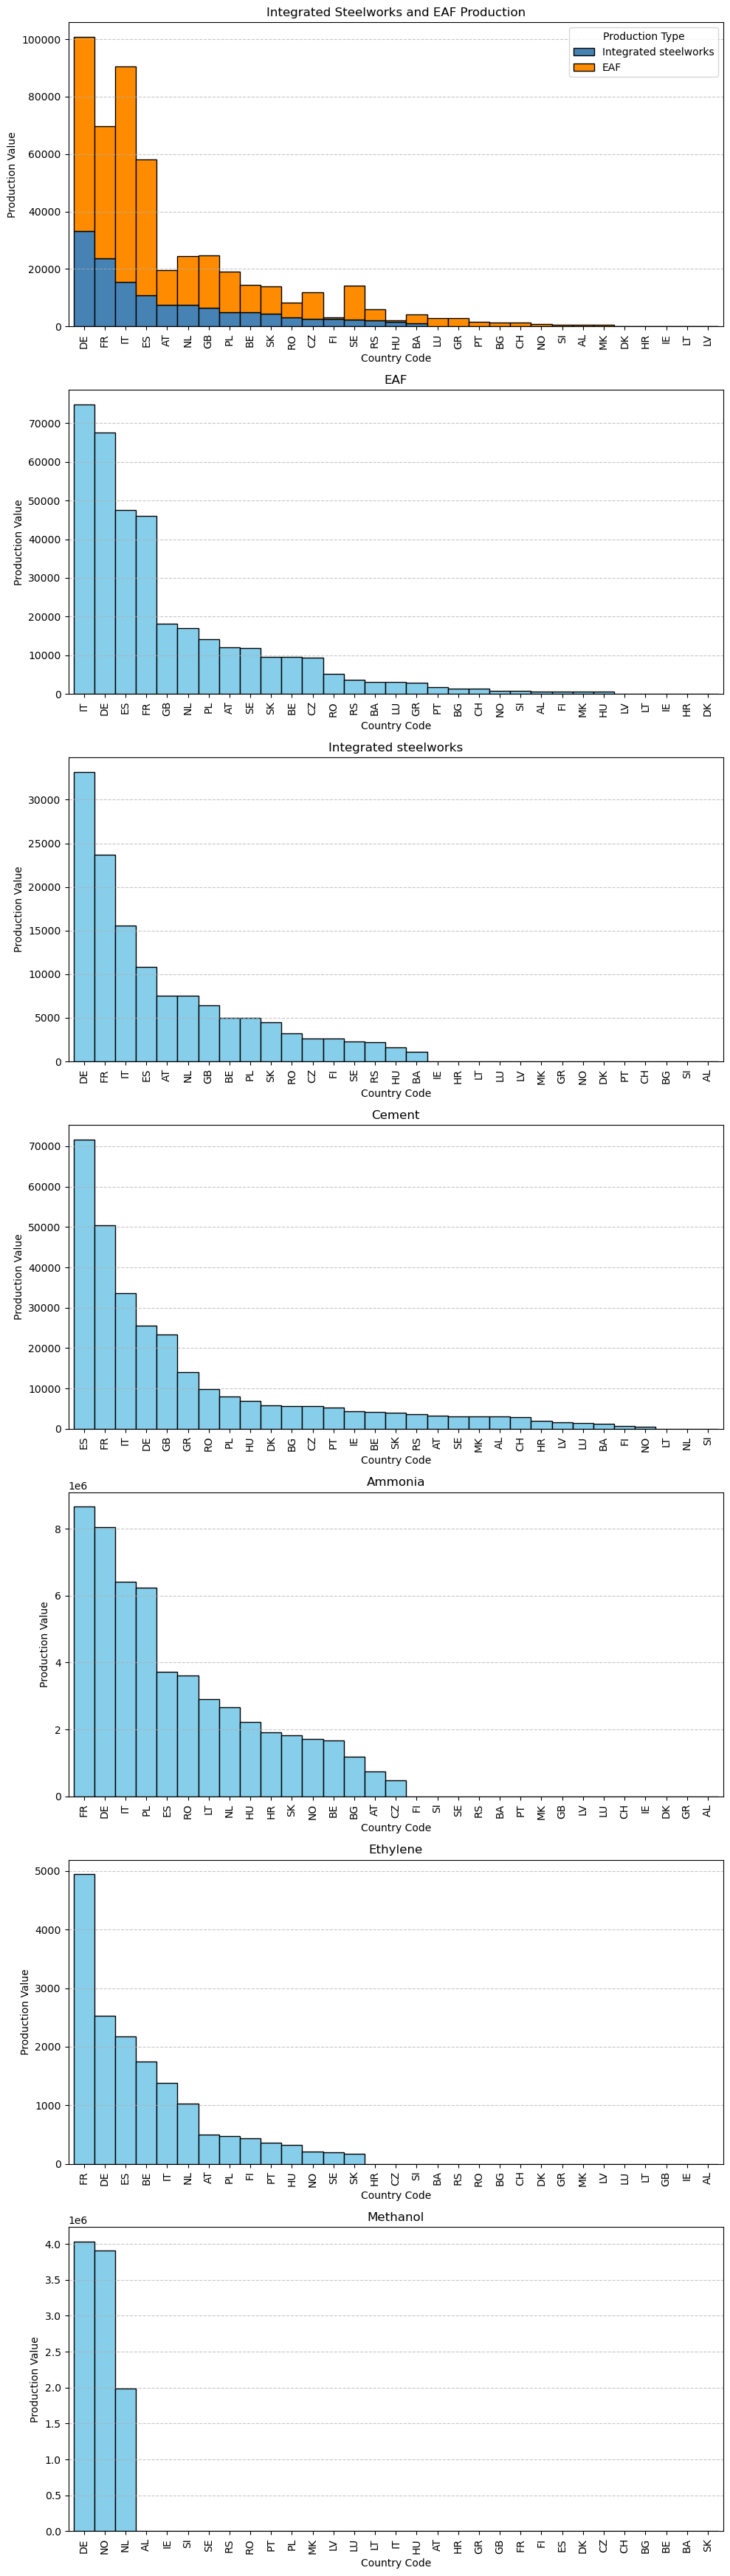

In [10]:

def plot_capacities(csv_file):
    # Load the CSV file
    df = pd.read_csv(csv_file, index_col=0)
    
    # Extract the first two letters of the index (country code) and group by it
    df.index = df.index.str[:2]
    df_grouped = df.groupby(df.index).sum()
    
    # Combine EAF and DRI + EAF under a single category 'EAF'
    if "EAF" in df_grouped.columns and "DRI + EAF" in df_grouped.columns:
        df_grouped["EAF"] = df_grouped["EAF"] + df_grouped["DRI + EAF"]
        df_grouped.drop(columns=["DRI + EAF"], inplace=True)
    
    # Apply the multipliers
    if "Ammonia" in df_grouped.columns:
        df_grouped["Ammonia"] *= 5166
    if "Methanol" in df_grouped.columns:
        df_grouped["Methanol"] *= 5528
    
    # Remove countries with values below 0.1
    df_grouped = df_grouped.loc[(df_grouped > 0.1).any(axis=1)]
    
    # Create a stacked vertical bar plot for Integrated Steelworks and EAF
    relevant_columns = ["Integrated steelworks", "EAF"]
    df_filtered = df_grouped[relevant_columns].dropna()
    df_filtered = df_filtered.sort_values(by=relevant_columns, ascending=False)
    
    fig, axes = plt.subplots(nrows=len(df_grouped.columns) + 1, figsize=(10, 5 * (len(df_grouped.columns) + 1)))
    
    # Plot the stacked bar plot for Integrated Steelworks and EAF
    df_filtered.plot(kind="bar", stacked=True, ax=axes[0], width=1, color=["steelblue", "darkorange"], edgecolor="black")
    axes[0].set_title("Integrated Steelworks and EAF Production")
    axes[0].set_xlabel("Country Code")
    axes[0].set_ylabel("Production Value")
    axes[0].legend(title="Production Type")
    axes[0].grid(axis="y", linestyle="--", alpha=0.7)
    
    # Plot each remaining column separately
    for i, column in enumerate(df_grouped.columns, start=1):

        df_sorted = df_grouped[column].sort_values(ascending=False)
        df_sorted.plot(kind="bar", ax=axes[i], color="skyblue", edgecolor="black", width=1)
        axes[i].set_title(column)
        axes[i].set_xlabel("Country Code")
        axes[i].set_ylabel("Production Value")
        axes[i].grid(axis="y", linestyle="--", alpha=0.7)
    
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
# Example usage
plot_capacities("capacities_s_39.csv")
